# **CAPSTONE PROJECT - CV**


## **PROBLEM STATEMENT**
**• DOMAIN: Health Care**

**• CONTEXT:**
Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation
of the lungs. In this challenge, you’re required to build an algorithm to detect a visual signal for pneumonia in medical
images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.

**• DATA DESCRIPTION:**
- In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was
determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the
appearance of true pneumonia. Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data.
- Dataset has been attached along with this project. Please use the same for this capstone project.
- Original link to the dataset :
  
  https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

You can refer to the details of the dataset in the above link
- Acknowledgements:

  https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements.

## **PROJECT OBJECTIVE:**
Design a DL based algorithm for detecting pneumonia.

**• PROJECT TASK:**
## 1. Milestone 1:

### ‣ Input: Context and Dataset
‣ Process:

‣ Step 1: Import the data.

‣ Step 2: Map training and testing images to its classes.

‣ Step 3: Map training and testing images to its annotations.

‣ Step 4: Preprocessing and Visualisation of different classes

‣ Step 5: Display images with bounding box.

‣ Step 6: Design, train and test basic CNN models for classification.

‣ Step 7: Interim report
‣ Submission: Interim report, Jupyter Notebook with all the steps in Milestone-1


# ***Import Libraries:***

In [9]:
pip install pydicom

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 1.8/1.8 MB 793.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [6]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import pydicom as dcm
import math
from tensorflow.keras.layers import Layer, Convolution2D, Flatten, Dense
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence

import pydicom
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle


# **‣ Step 1: Import the data.**

In [7]:
classInfo = pd.read_csv(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_detailed_class_info.csv')
trainlabels = pd.read_csv(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv')
trainImagesPath = Path(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_images')
testImagesPath = Path(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_test_images')
sampleSubPath = Path(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_sample_submission.csv')

# **EDA**

# **Reading the class Info Data Set**

In [8]:
## Examining the labels dataset and displaying the initial few records.
classInfo = pd.read_csv(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_detailed_class_info.csv')

In [9]:
classInfo.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [10]:
classInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


# **There are two features 1. Patient ID 2. Class**

In [11]:
classInfo.shape

(30227, 2)

In [12]:
classInfo.patientId.nunique()

26684

# There are 26684 distinct patient profiles available among a total of 30227 records, indicating potential duplications for certain patient IDs. Let's investigate further.

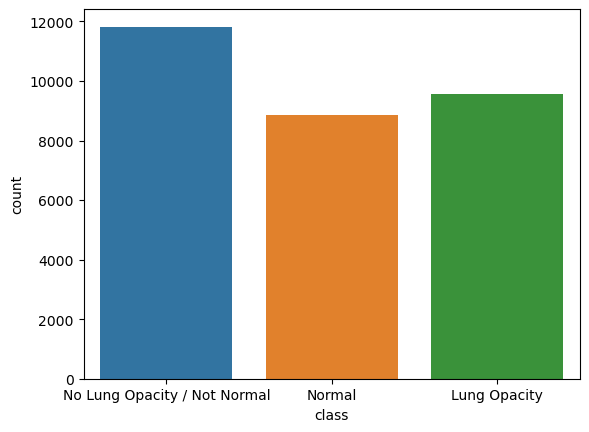

In [13]:
sns.countplot(x='class',data=classInfo);

# Images from different classes 1.Normal; 2.No Lung Opacity / Not Normal; 3.Lung Opacity

In [14]:
def get_feature_distribution(data, feature):
    # Get the count for each label
    label_counts = data[feature].value_counts()

    # Get total number of samples
    total_samples = len(data)

    # Count the number of items in each class
    print("Feature: {}".format(feature))
    for i in range(len(label_counts)):
        label = label_counts.index[i]
        count = label_counts.values[i]
        percent = int((count / total_samples) * 10000) / 100
        print("{:<30s}:   {} or {}%".format(label, count, percent))

get_feature_distribution(classInfo, 'class')

Feature: class
No Lung Opacity / Not Normal  :   11821 or 39.1%
Lung Opacity                  :   9555 or 31.61%
Normal                        :   8851 or 29.28%


In [15]:
classInfo[classInfo.duplicated()]

patientId         class
5      00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
9      00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
15     00aecb01-a116-45a2-956c-08d2fa55433f  Lung Opacity
17     00c0b293-48e7-4e16-ac76-9269ba535a62  Lung Opacity
20     00f08de1-517e-4652-a04f-d1dc9ee48593  Lung Opacity
...                                     ...           ...
30209  c18d1138-ba74-4af5-af21-bdd4d2c96bb5  Lung Opacity
30215  c1cddf32-b957-4753-acaa-472ab1447e86  Lung Opacity
30220  c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2  Lung Opacity
30222  c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity

[3543 rows x 2 columns]

# As we suspected there are 3543 duplicated records.

In [16]:
classInfo[classInfo.duplicated()].shape

(3543, 2)

In [17]:
classInfo[classInfo.patientId=='c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId         class
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  Lung Opacity

# **Check for missing values**

In [18]:
def missing_check(df):
    total = df.isnull().sum().sort_values(ascending=False)  # total number of null values
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(
        ascending=False)  # percentage of values that are null
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])  # putting the above two together
    return missing_data  # return the dataframe

In [19]:
missing_check(classInfo)

Total  Percent
patientId      0      0.0
class          0      0.0

**There are no missing values.**

# As we suspected there are 3543 duplicated records.

In [20]:
classInfo.shape

(30227, 2)

In [21]:
duplicateClassRowsDF = classInfo[classInfo.duplicated(['patientId'])]
duplicateClassRowsDF.shape

(3543, 2)

In [22]:
duplicateClassRowsDF.head(2)

patientId         class
5  00436515-870c-4b36-a041-de91049b9ab4  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity

In [23]:
## The same patient id has the same class even though they are duplicate
classInfo[classInfo.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

patientId         class
8  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity
9  00704310-78a8-4b38-8475-49f4573b2dbb  Lung Opacity

# **Reading the trainlabels dataSet**

In [24]:
trainlabels = pd.read_csv(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv')
trainlabels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [25]:
trainlabels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [26]:
trainlabels.shape

(30227, 6)

# The training labels consist of 30227 records, aligning with the metadata dataset of the same size

In [27]:
trainlabels.patientId.nunique()

26684

# The count of unique patient IDs also corresponds to the class information. Now, let's verify the class information for the same set of patients

In [28]:
trainlabels[trainlabels.patientId=='c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId      x      y  width  height  \
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target  
30225       1  
30226       1

# Two records exist for the same patient, each with different dimensions. This discrepancy might be attributed to the detection of X-ray opacity at multiple locations.

In [29]:
trainlabels[trainlabels.duplicated()]

Empty DataFrame
Columns: [patientId, x, y, width, height, Target]
Index: []

# There are no duplicate records for train labels.

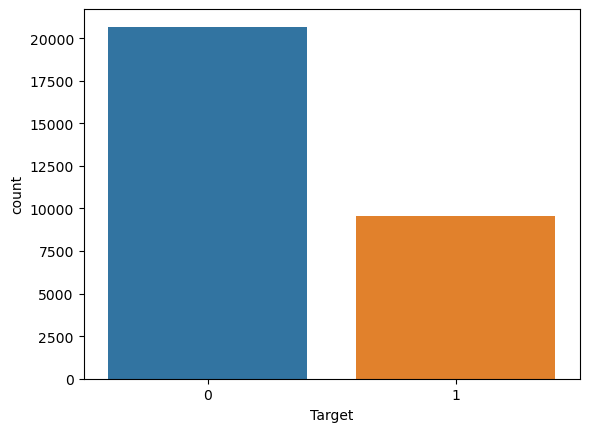

In [30]:
sns.countplot(x='Target',data=trainlabels);

# The "Target" column contains two values, namely 1 or 0. However, in the "ClassInfo," three distinct classes are observed. Let's delve deeper to explore the relationship between the "Target" and "Class" columns.

In [31]:
missing_check(trainlabels)

Total   Percent
x          20672  0.683892
y          20672  0.683892
width      20672  0.683892
height     20672  0.683892
patientId      0  0.000000
Target         0  0.000000

In [32]:
trainlabels[trainlabels.x.isna()]

patientId   x   y  width  height  Target
0      0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0
1      00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0
2      00322d4d-1c29-4943-afc9-b6754be640eb NaN NaN    NaN     NaN       0
3      003d8fa0-6bf1-40ed-b54c-ac657f8495c5 NaN NaN    NaN     NaN       0
6      00569f44-917d-4c86-a842-81832af98c30 NaN NaN    NaN     NaN       0
...                                     ...  ..  ..    ...     ...     ...
30216  c1cf3255-d734-4980-bfe0-967902ad7ed9 NaN NaN    NaN     NaN       0
30217  c1e228e4-b7b4-432b-a735-36c48fdb806f NaN NaN    NaN     NaN       0
30218  c1e3eb82-c55a-471f-a57f-fe1a823469da NaN NaN    NaN     NaN       0
30223  c1edf42b-5958-47ff-a1e7-4f23d99583ba NaN NaN    NaN     NaN       0
30224  c1f6b555-2eb1-4231-98f6-50a963976431 NaN NaN    NaN     NaN       0

[20672 rows x 6 columns]

# Some records lack X and Y values, potentially because these measurements may not be applicable for normal patients

In [33]:
trainlabels[trainlabels.x.isna()]['Target'].unique()

array([0], dtype=int64)

# Its proved that only for normal patients dimensions are not available.

In [34]:
trainlabels.describe()

x            y        width       height        Target
count  9555.000000  9555.000000  9555.000000  9555.000000  30227.000000
mean    394.047724   366.839560   218.471376   329.269702      0.316108
std     204.574172   148.940488    59.289475   157.750755      0.464963
min       2.000000     2.000000    40.000000    45.000000      0.000000
25%     207.000000   249.000000   177.000000   203.000000      0.000000
50%     324.000000   365.000000   217.000000   298.000000      0.000000
75%     594.000000   478.500000   259.000000   438.000000      1.000000
max     835.000000   881.000000   528.000000   942.000000      1.000000

# 75% of the data represents target value 1. Count plot also shows the same. So looks its an imbalanced data set.

# Lets concatenate classInfo and trainlabels . Before concatinating them lets remove duplicate records from class info.

In [35]:
classInfo.drop_duplicates(inplace=True)

In [36]:
classInfo.shape

(26684, 2)

In [37]:
## we can see that all the null column values are with Target 0 indicating that those patients do not have penumonia
trainlabels[trainlabels.isnull().any(axis=1)].Target.value_counts()

0    20672
Name: Target, dtype: int64

In [38]:
## we can see that all the non null column values are with Target 1 indicating that those patients have pneumonia
trainlabels[~trainlabels.isnull().any(axis=1)].Target.value_counts()

1    9555
Name: Target, dtype: int64

In [39]:
## Distubution of Targets , there are 20672 records with no pneumonia and 9555 with pneumonia
trainlabels.Target.value_counts()

0    20672
1     9555
Name: Target, dtype: int64

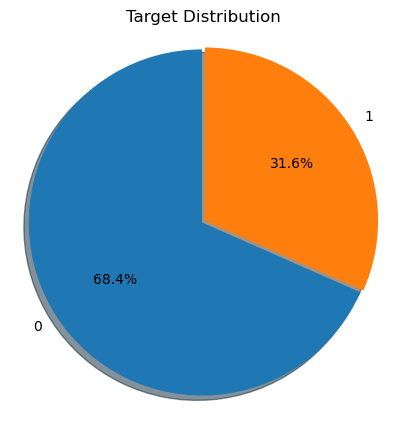

In [40]:
## The distribution of the target variable shows that 31% of patients in the dataset have pneumonia,
## while the rest do not. This indicates a class imbalance issue within the dataset.
label_count=trainlabels['Target'].value_counts()
explode = (0.01,0.01)

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Target Distribution')
plt.show()

In [41]:
print("Are there Unique Patients In Data Set ?? " ,trainlabels['patientId'].is_unique)

Are there Unique Patients In Data Set ??  False


In [42]:
duplicateRowsDF = trainlabels[trainlabels.duplicated(['patientId'])]
duplicateRowsDF.shape

(3543, 6)

In [43]:
duplicateRowsDF.head(2)

patientId      x      y  width  height  Target
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [44]:
## Examining one of the patient id which is duplicate , we can see that the x,y, widht and height is not the same
## This indicates that the same patient has two bounding boxes in the same dicom image
trainlabels[trainlabels.patientId=='00436515-870c-4b36-a041-de91049b9ab4']

patientId      x      y  width  height  Target
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1

In [45]:
trainlabels[trainlabels.patientId=='00704310-78a8-4b38-8475-49f4573b2dbb']

patientId      x      y  width  height  Target
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

# **Step 2: Map training and testing images to its classes.**

In [46]:
traindf = trainlabels.merge(classInfo, left_on='patientId', right_on='patientId', how='inner')

In [47]:
traindf.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

# Lets check for specific patient how data has been concatinated.

In [48]:
traindf[traindf.patientId=='c1f7889a-9ea9-4acb-b64c-b737c929599a']

patientId      x      y  width  height  \
30225  c1f7889a-9ea9-4acb-b64c-b737c929599a  570.0  393.0  261.0   345.0   
30226  c1f7889a-9ea9-4acb-b64c-b737c929599a  233.0  424.0  201.0   356.0   

       Target         class  
30225       1  Lung Opacity  
30226       1  Lung Opacity

# Good, same patient has different dimension values with same target value.
# Now lets see how class and target are related to each other??


In [49]:
traindf.Target.unique()

array([0, 1], dtype=int64)

In [50]:
traindf.groupby(['class', 'Target']).size().reset_index(name='Patient Count')

class  Target  Patient Count
0                  Lung Opacity       1           9555
1  No Lung Opacity / Not Normal       0          11821
2                        Normal       0           8851

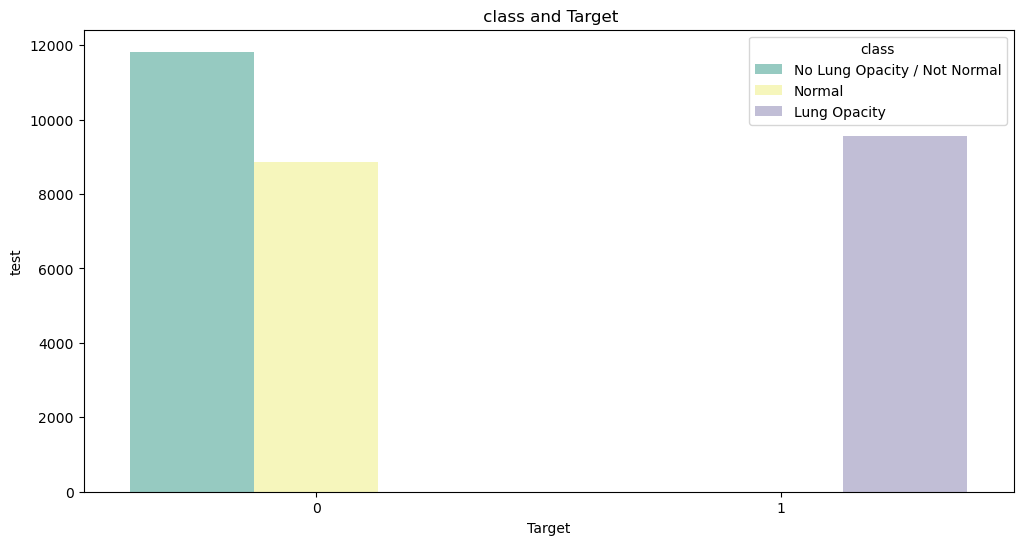

In [51]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = traindf.groupby('Target')['class'].value_counts()
df = pd.DataFrame(data={'test': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'Target', y='test',hue='class',data=df, palette='Set3')
plt.title(" class and Target")
plt.show()

# classifying "Normal" and "No Lung Opacity / Not Normal" into a single target value '0'. Therefore, we can conclude that the prediction task is a binary classification, determining whether a patient has lung opacity or not. The classes "Normal" and "Not Normal" have been merged into the same target category.

# Prediction: Binary classification i.e. Patient has Lung Opacity or not?

<AxesSubplot:>

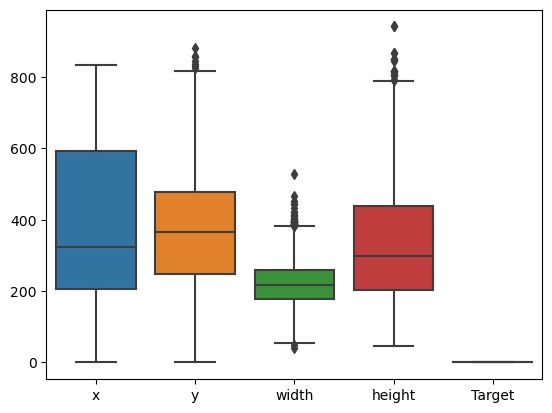

In [52]:
sns.boxplot(data=traindf)

In [53]:
traindf.corr()

x         y     width    height  Target
x       1.000000  0.007604 -0.058665  0.008256     NaN
y       0.007604  1.000000 -0.299897 -0.645369     NaN
width  -0.058665 -0.299897  1.000000  0.597461     NaN
height  0.008256 -0.645369  0.597461  1.000000     NaN
Target       NaN       NaN       NaN       NaN     1.0

<Figure size 640x480 with 0 Axes>

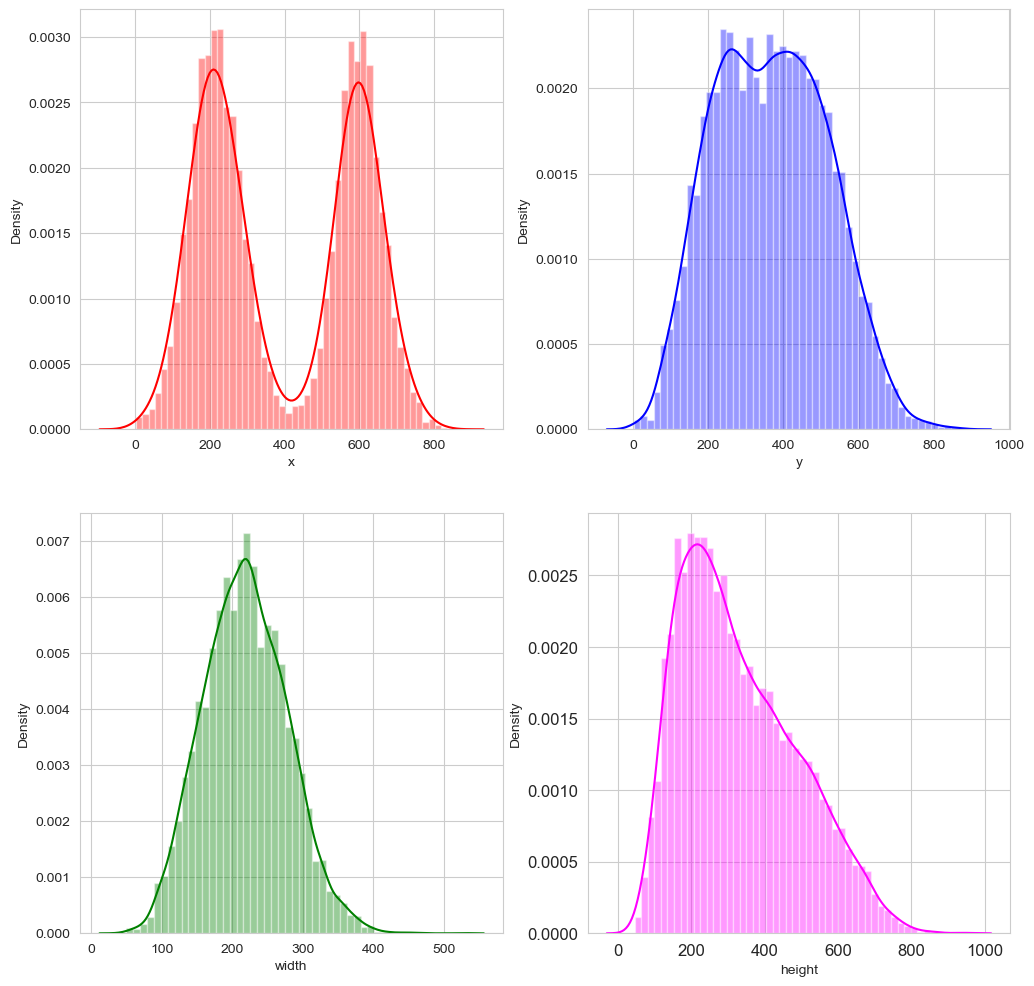

In [54]:
target1 = traindf[traindf['Target']==1]
sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(2,2,figsize=(12,12))
sns.distplot(target1['x'],kde=True,bins=50, color="red", ax=ax[0,0]);
sns.distplot(target1['y'],kde=True,bins=50, color="blue", ax=ax[0,1]);
sns.distplot(target1['width'],kde=True,bins=50, color="green", ax=ax[1,0]);
sns.distplot(target1['height'],kde=True,bins=50, color="magenta", ax=ax[1,1]);
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

In [55]:
trainImagesPath = Path(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_images')
testImagesPath = Path(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_test_images')

In [56]:
import os;
image_train_path = os.listdir(trainImagesPath)
image_test_path = os.listdir(testImagesPath)

print("Number of images in train set:", len(image_train_path),"\nNumber of images in test set:", len(image_test_path))

Number of images in train set: 26684 
Number of images in test set: 3000


# Train images length matched with unique patient id's in traindf.

# **Step 3: Map training and testing images to its annotations.**

In [57]:
samplePatientID = list(traindf[:3].T.to_dict().values())[0]['patientId']
dcm_path = trainImagesPath/samplePatientID
dcm_path = dcm_path.with_suffix(".dcm")
dcm = pydicom.read_file(dcm_path)
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

# **‣ Step 4: Preprocessing and Visualisation of different classes**

# We can observe that within the DICOM metadata, there is valuable information with predictive value. For instance:
## Patient sex;
## Patient age;
## Modality;
## Body part examined;
## View position;
## Rows & Columns;
## Pixel Spacing.



In [58]:
def show_dicom_images(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        dcm_path = trainImagesPath/data_row['patientId']
        dcm_path = dcm_path.with_suffix(".dcm")
        data_row_img_data = pydicom.read_file(dcm_path)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        ax[i//3, i%3].imshow(data_row_img_data.pixel_array, cmap=plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}\nWindow: {}:{}:{}:{}'.format(
                data_row['patientId'],
                modality, age, sex, data_row['Target'], data_row['class'],
                data_row['x'],data_row['y'],data_row['width'],data_row['height']))
    plt.show()

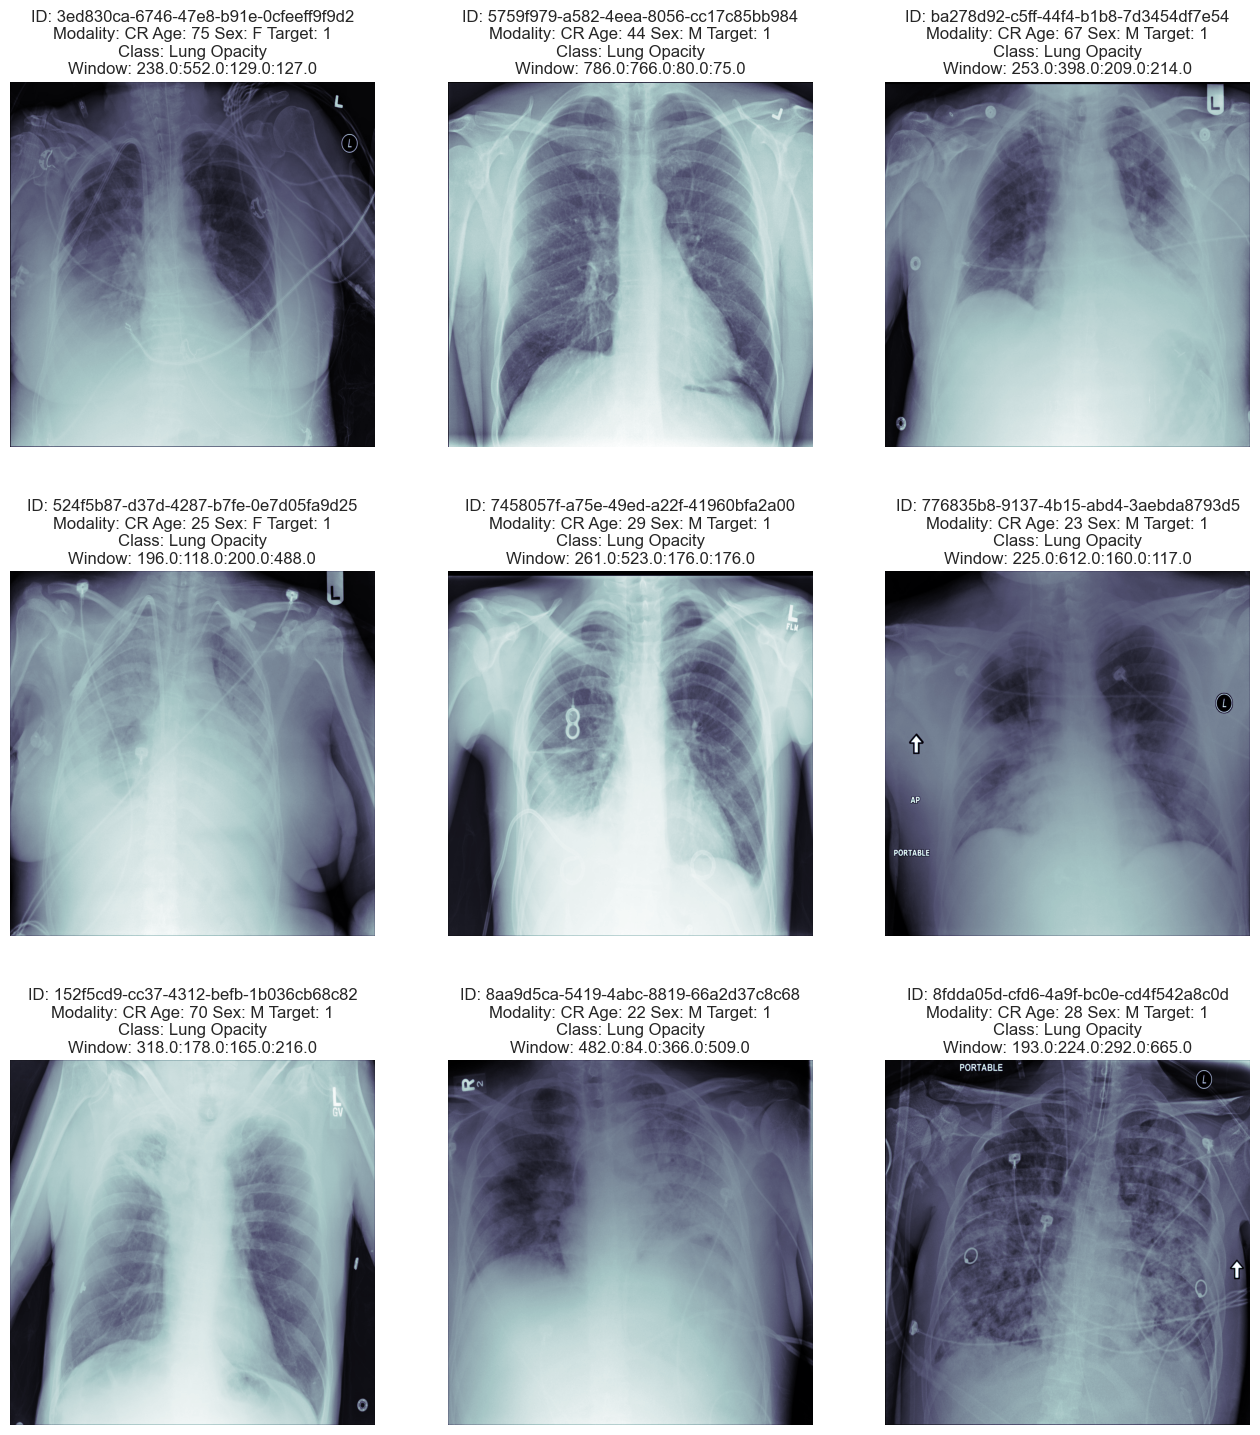

In [59]:
show_dicom_images(traindf[traindf['Target']==1].sample(9))

# To visualize the images with overlay boxes superimposed, our initial step involves parsing the entire dataset where the target is equal to 1. Subsequently, we will gather all the coordinates of windows displaying lung opacity on the same image.

# **‣ Step 5: Display images with bounding box.**

In [60]:
def show_dicom_images_with_boxes(data):
    img_data = list(data.T.to_dict().values())
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(img_data):
        dcm_path = trainImagesPath/data_row['patientId']
        dcm_path = dcm_path.with_suffix(".dcm")
        data_row_img_data = pydicom.read_file(dcm_path)
        modality = data_row_img_data.Modality
        age = data_row_img_data.PatientAge
        sex = data_row_img_data.PatientSex
        ax[i//3, i%3].imshow(data_row_img_data.pixel_array, cmap=plt.cm.bone)
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nModality: {} Age: {} Sex: {} Target: {}\nClass: {}'.format(
                data_row['patientId'],modality, age, sex, data_row['Target'], data_row['class']))
        rows = traindf[traindf['patientId']==data_row['patientId']]
        box_data = list(rows.T.to_dict().values())
        for j, row in enumerate(box_data):
            ax[i//3, i%3].add_patch(Rectangle(xy=(row['x'], row['y']),
                        width=row['width'],height=row['height'],
                       linewidth=2, edgecolor='r', facecolor='none'))
    plt.show()

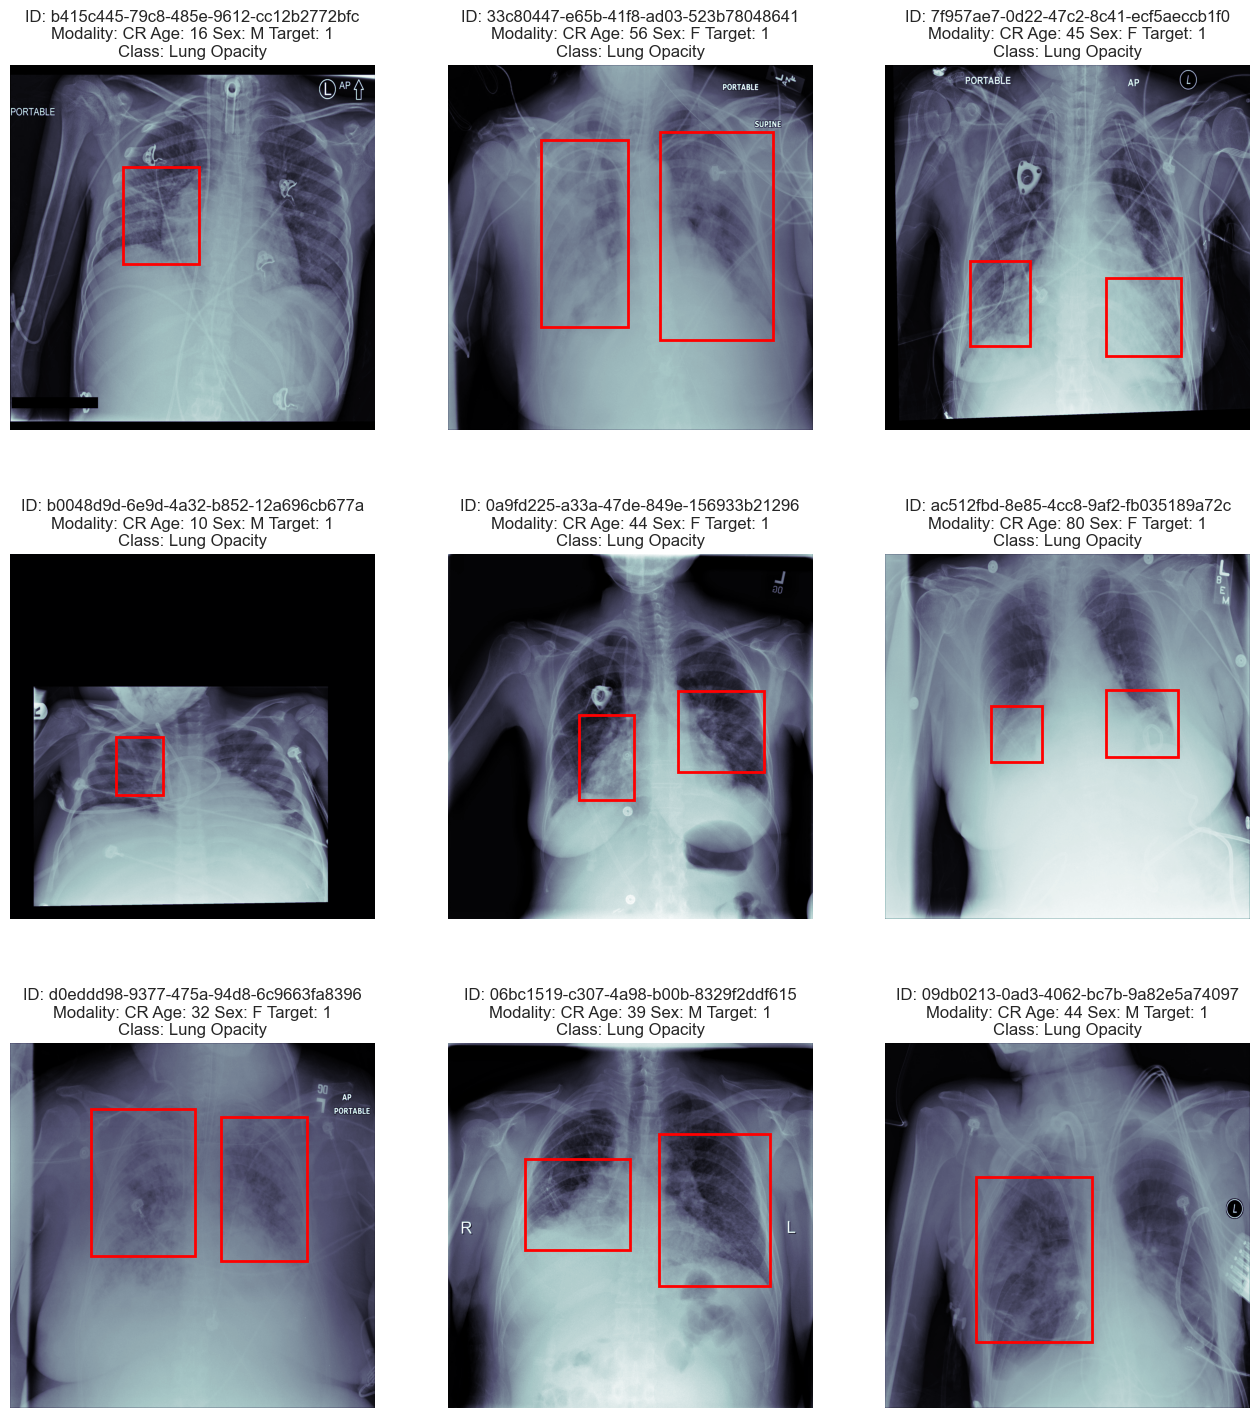

In [61]:
show_dicom_images_with_boxes(traindf[traindf['Target']==1].sample(9))

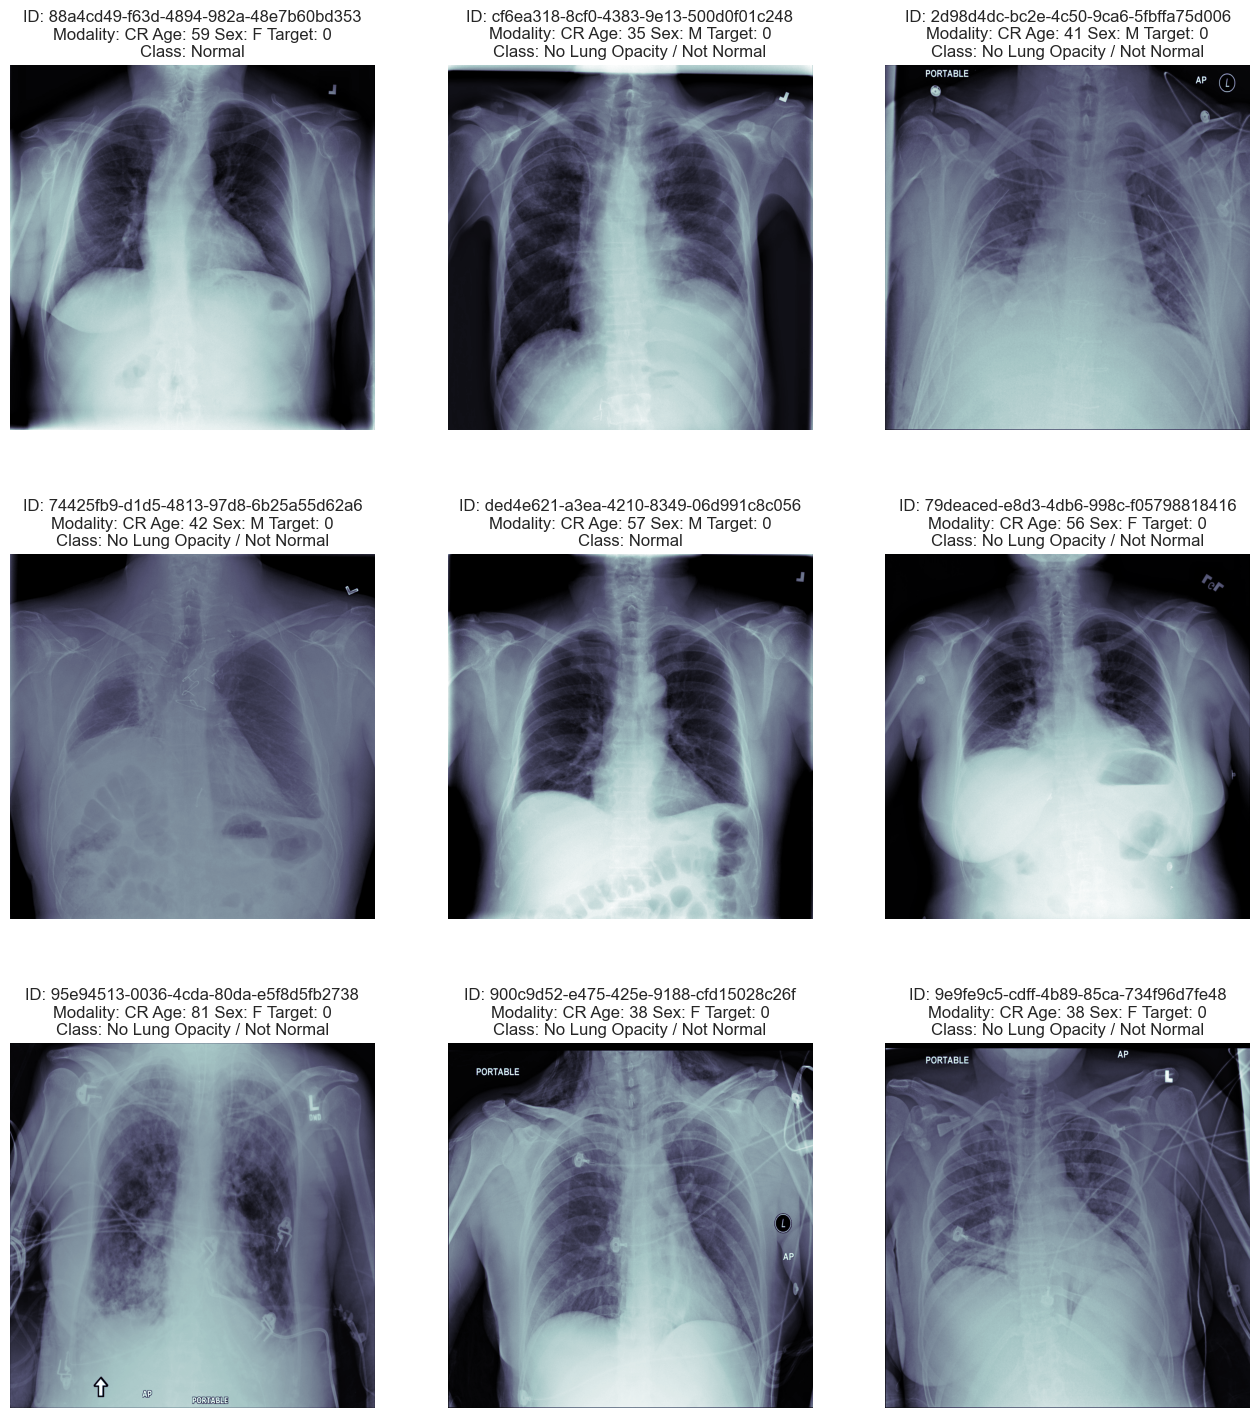

In [62]:
show_dicom_images_with_boxes(traindf[traindf['Target']==0].sample(9))

In [63]:
from tqdm.notebook import tqdm

In [64]:
vars = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def process_dicom_data(data_df,imagesPath):
    for var in vars:
        data_df[var] = None
    image_names = os.listdir(imagesPath)
    for i, img_name in tqdm_notebook(enumerate(image_names)):

        dcm_path = imagesPath/img_name
        dcm_path = dcm_path.with_suffix(".dcm")
        data_row_img_data = pydicom.read_file(dcm_path)
        idx = (data_df['patientId']==data_row_img_data.PatientID)
        data_df.loc[idx,'Modality'] = data_row_img_data.Modality
        data_df.loc[idx,'PatientAge'] = pd.to_numeric(data_row_img_data.PatientAge)
        data_df.loc[idx,'PatientSex'] = data_row_img_data.PatientSex
        data_df.loc[idx,'BodyPartExamined'] = data_row_img_data.BodyPartExamined
        data_df.loc[idx,'ViewPosition'] = data_row_img_data.ViewPosition
        data_df.loc[idx,'ConversionType'] = data_row_img_data.ConversionType
        data_df.loc[idx,'Rows'] = data_row_img_data.Rows
        data_df.loc[idx,'Columns'] = data_row_img_data.Columns
        data_df.loc[idx,'PixelSpacing'] = str.format("{:4.3f}",data_row_img_data.PixelSpacing[0])


In [65]:
process_dicom_data(traindf,trainImagesPath)

C:\Users\manve\AppData\Local\Temp\ipykernel_3252\558203940.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, img_name in tqdm_notebook(enumerate(image_names)):


0it [00:00, ?it/s]

In [66]:
traindf.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class Modality PatientAge PatientSex  \
0  No Lung Opacity / Not Normal       CR         51          F   
1  No Lung Opacity / Not Normal       CR         48          F   
2  No Lung Opacity / Not Normal       CR         19          M   
3                        Normal       CR         28          M   
4                  Lung Opacity       CR         32          F   

  BodyPartExamined ViewPosition ConversionType  Rows Columns PixelSpacing  
0            CHEST           PA            WSD  1024    1024        0.143  
1            CHEST           PA            WSD  1024    1024        0.194  
2            CHEST           AP            WSD  1024    1024        0.168  
3            CHEST           PA            WSD  1024    1024        0.143  
4            CHEST           AP            WSD  1024    1024        0.139

In [67]:
testdf = pd.read_csv(sampleSubPath)

In [68]:
testdf = testdf.drop('PredictionString',1)
process_dicom_data(testdf,testImagesPath)

C:\Users\manve\AppData\Local\Temp\ipykernel_3252\558203940.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, img_name in tqdm_notebook(enumerate(image_names)):


0it [00:00, ?it/s]

In [69]:
testdf.head()

patientId Modality PatientAge PatientSex  \
0  0000a175-0e68-4ca4-b1af-167204a7e0bc       CR         46          F   
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813       CR         22          F   
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6       CR         64          M   
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d       CR         75          F   
4  00100a24-854d-423d-a092-edcf6179e061       CR         66          F   

  BodyPartExamined ViewPosition ConversionType  Rows Columns PixelSpacing  
0            CHEST           PA            WSD  1024    1024        0.194  
1            CHEST           PA            WSD  1024    1024        0.143  
2            CHEST           PA            WSD  1024    1024        0.143  
3            CHEST           PA            WSD  1024    1024        0.143  
4            CHEST           AP            WSD  1024    1024        0.139

**Modality**

In [70]:
traindf.Modality.unique()

array(['CR'], dtype=object)

In [71]:
testdf.Modality.unique()

array(['CR'], dtype=object)

**The meaning of this modality is CR - Computer Radiography**

**Patient Age**

In [72]:
traindf['PatientAge'].value_counts()

58     955
56     869
52     791
55     767
54     717
      ... 
148      1
151      1
153      1
150      1
155      1
Name: PatientAge, Length: 97, dtype: int64

In [73]:
traindf['PatientAge'].max()

155

In [74]:
traindf['PatientAge'].min()

1

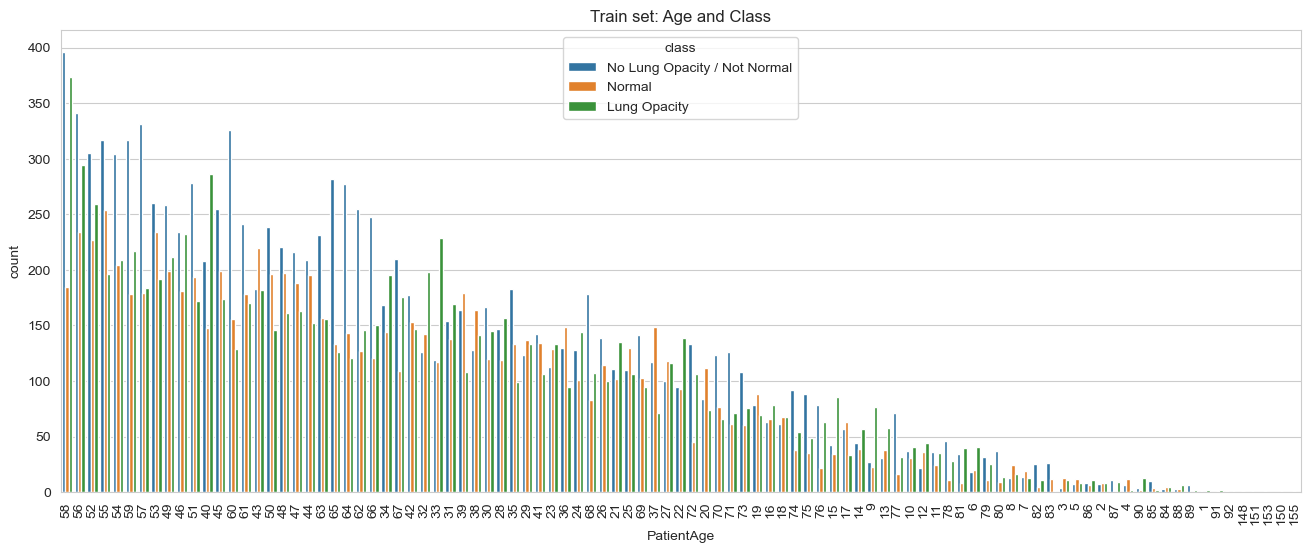

In [75]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.countplot(ax=ax, x = 'PatientAge',hue='class',data=traindf, order = traindf['PatientAge'].value_counts().index)
plt.title("Train set: Age and Class")
plt.xticks(rotation=90)
plt.show()

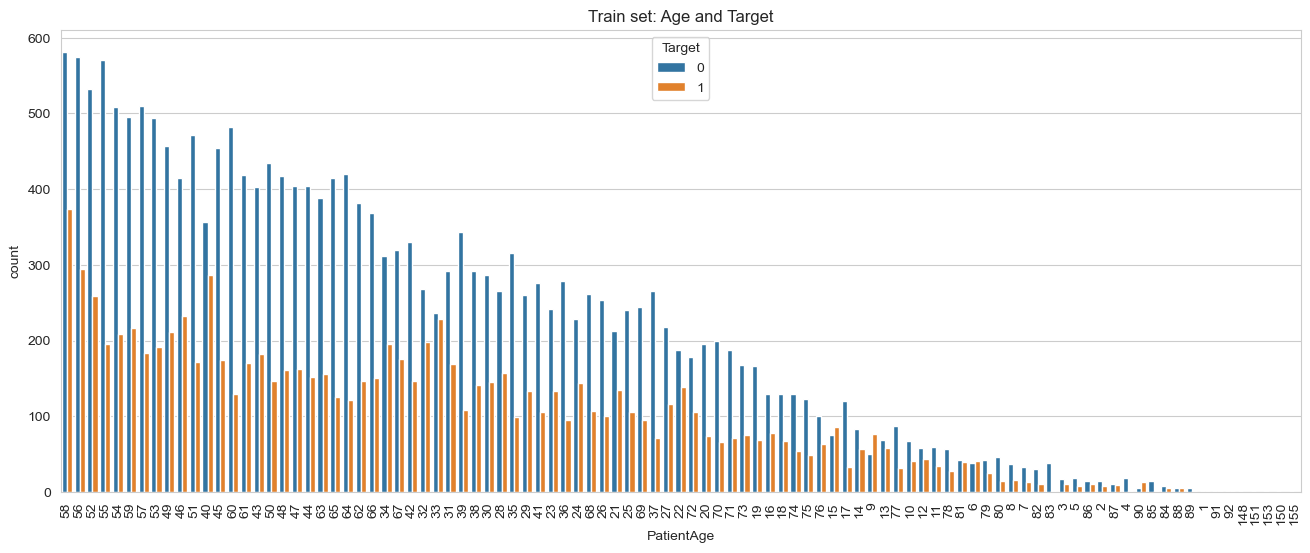

In [76]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.countplot(ax=ax, x = 'PatientAge',hue='Target',data=traindf, order = traindf['PatientAge'].value_counts().index)
plt.title("Train set: Age and Target")
plt.xticks(rotation=90)
plt.show()

The majority of the data is recorded for individuals aged between 40 to 50. However, an outlier is present with an age of 151. There are limited data points for age groups between 1 to 5 and 80 to 90.

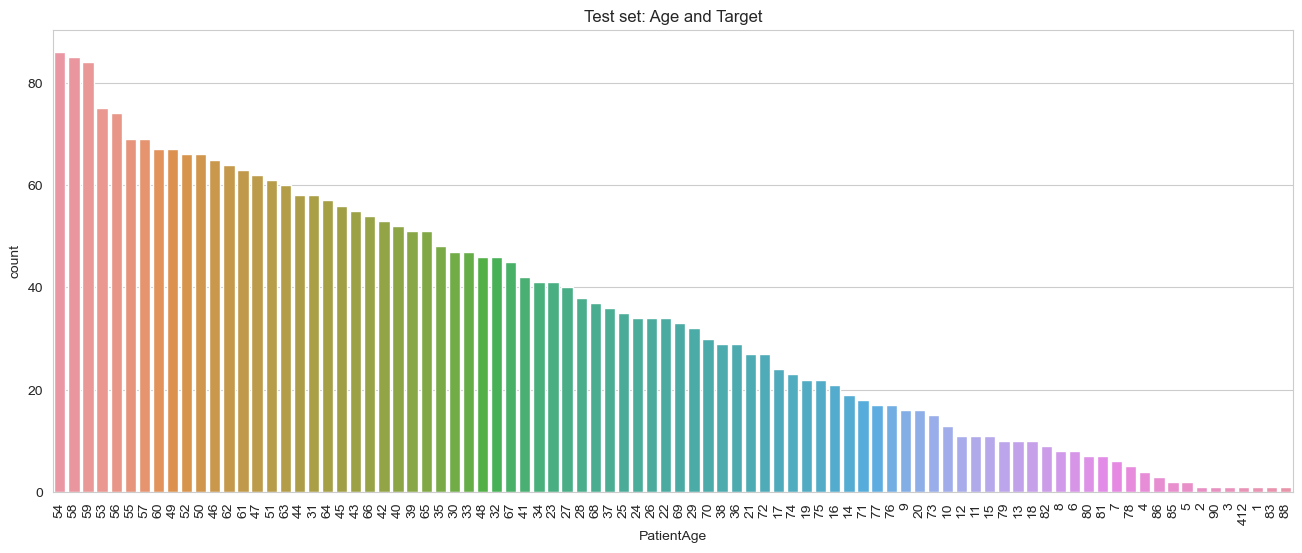

In [77]:
fig, (ax) = plt.subplots(nrows=1,figsize=(16,6))
sns.countplot(ax=ax, x = 'PatientAge',data=testdf, order = testdf['PatientAge'].value_counts().index)
plt.title("Test set: Age and Target")
plt.xticks(rotation=90)
plt.show()

**In test set also similar kind of behaviour observed in data among different age groups. Outlier with Age 412**

**PatientSex**

In [78]:
traindf['PatientSex'].value_counts()

M    17216
F    13011
Name: PatientSex, dtype: int64

In [79]:
testdf['PatientSex'].value_counts()

M    1714
F    1286
Name: PatientSex, dtype: int64

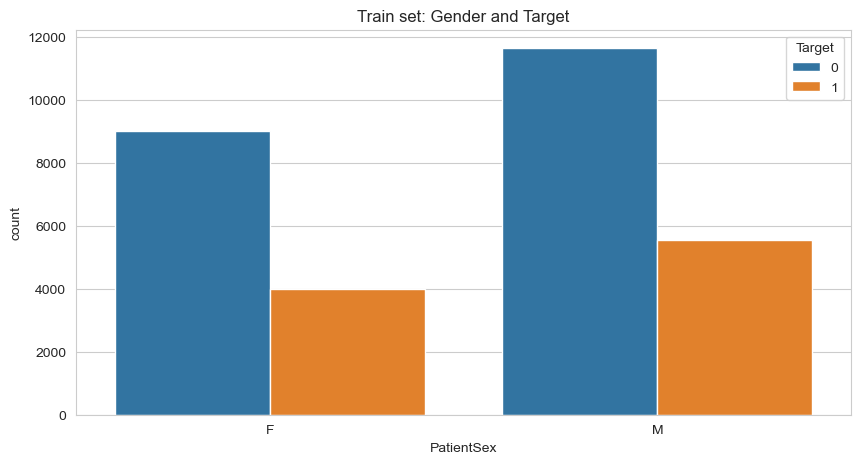

In [80]:
fig, (ax) = plt.subplots(nrows=1,figsize=(10,5))
sns.countplot(ax=ax, x = 'PatientSex',hue='Target',data=traindf)
plt.title("Train set: Gender and Target")
plt.show()

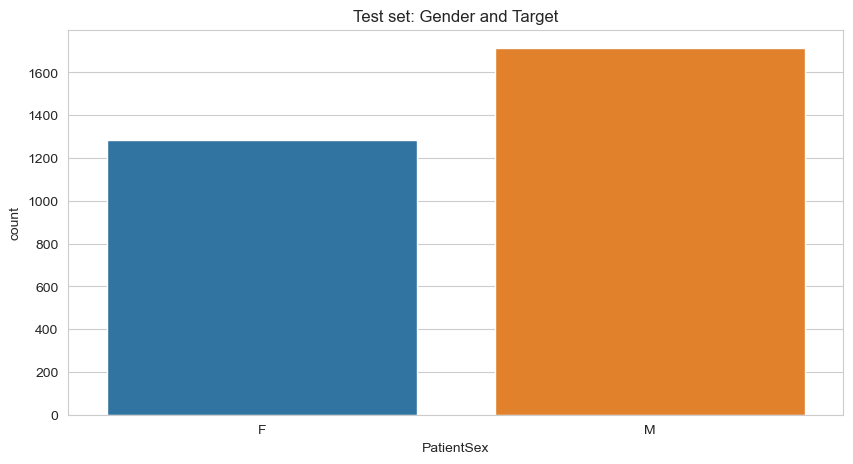

In [81]:
fig, (ax) = plt.subplots(nrows=1,figsize=(10,5))
sns.countplot(ax=ax, x = 'PatientSex',data=testdf)
plt.title("Test set: Gender and Target")
plt.show()

**BodyPartExamined**

In [82]:
traindf['BodyPartExamined'].value_counts()

CHEST    30227
Name: BodyPartExamined, dtype: int64

In [83]:
testdf['BodyPartExamined'].value_counts()

CHEST    3000
Name: BodyPartExamined, dtype: int64

**Unique values found for this column**

**ConversionType**

In [84]:
traindf['ConversionType'].value_counts()

WSD    30227
Name: ConversionType, dtype: int64

In [85]:
testdf['ConversionType'].value_counts()

WSD    3000
Name: ConversionType, dtype: int64

**Unique values found for this column**

**Rows Columns**

In [86]:
traindf['Rows'].value_counts()

1024    30227
Name: Rows, dtype: int64

In [87]:
traindf['Columns'].value_counts()

1024    30227
Name: Columns, dtype: int64

In [88]:
testdf['Rows'].value_counts(),testdf['Columns'].value_counts()

(1024    3000
 Name: Rows, dtype: int64,
 1024    3000
 Name: Columns, dtype: int64)

**Unique values found.**

**ViewPosition**

In [89]:
traindf['ViewPosition'].value_counts()

AP    15297
PA    14930
Name: ViewPosition, dtype: int64

<AxesSubplot:xlabel='ViewPosition', ylabel='count'>

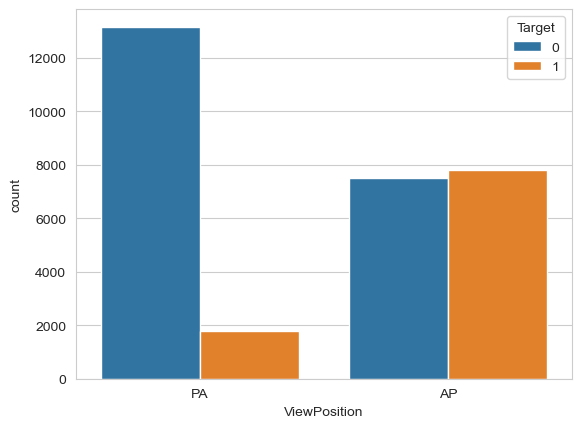

In [90]:
sns.countplot(x='ViewPosition',hue='Target',data=traindf)

<AxesSubplot:xlabel='ViewPosition', ylabel='count'>

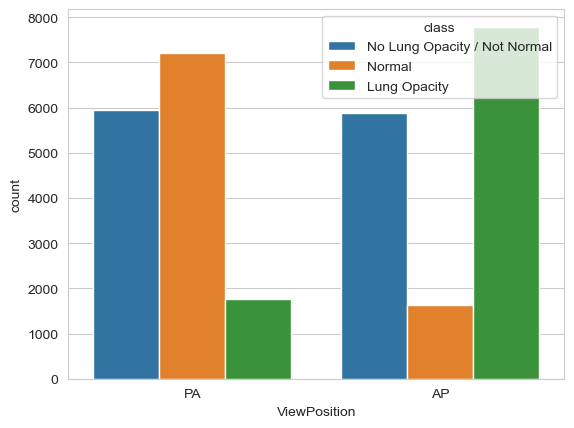

In [91]:
sns.countplot(x='ViewPosition',hue='class',data=traindf)

In [92]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()

traindf['ViewPosition']= label_encoder.fit_transform(traindf['ViewPosition'])
print(label_encoder.classes_)
traindf['ViewPosition'].unique()

['AP' 'PA']


array([1, 0])

<AxesSubplot:xlabel='ViewPosition', ylabel='count'>

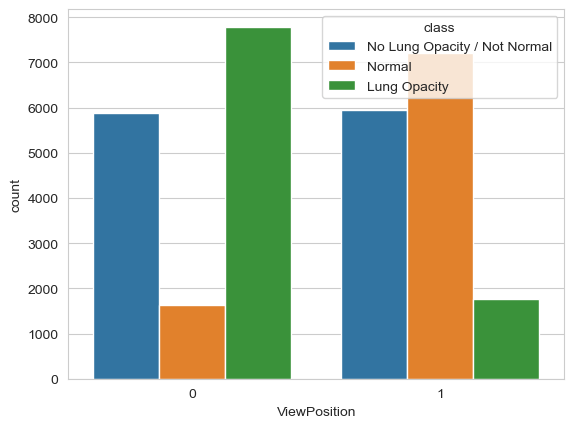

In [93]:
sns.countplot(x='ViewPosition',hue='class',data=traindf)

# **AP-AnteriorPosterior=0,  PA-PostereiorAterior=1**

In [94]:
testdf['ViewPosition'].value_counts()

PA    1618
AP    1382
Name: ViewPosition, dtype: int64

In [95]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

testdf['ViewPosition']= label_encoder.fit_transform(testdf['ViewPosition'])
print(label_encoder.classes_)
testdf['ViewPosition'].unique()

['AP' 'PA']


array([1, 0])

**PixelSpacing**

In [96]:
traindf['PixelSpacing'].value_counts()

0.168    10677
0.143     9221
0.139     6585
0.171     2351
0.194     1380
0.115        8
0.199        5
Name: PixelSpacing, dtype: int64

<AxesSubplot:xlabel='PixelSpacing', ylabel='count'>

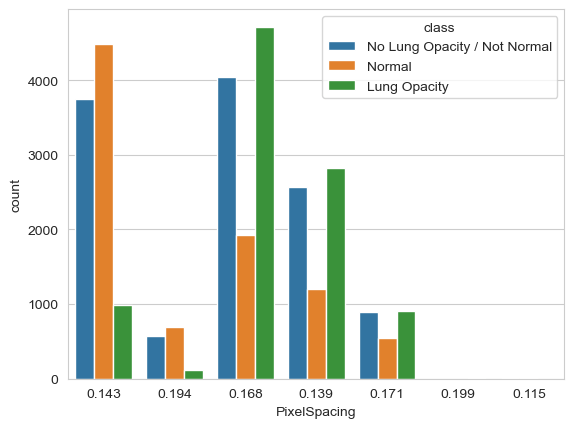

In [97]:
sns.countplot(x='PixelSpacing',hue='class',data=traindf)

<AxesSubplot:xlabel='PixelSpacing', ylabel='count'>

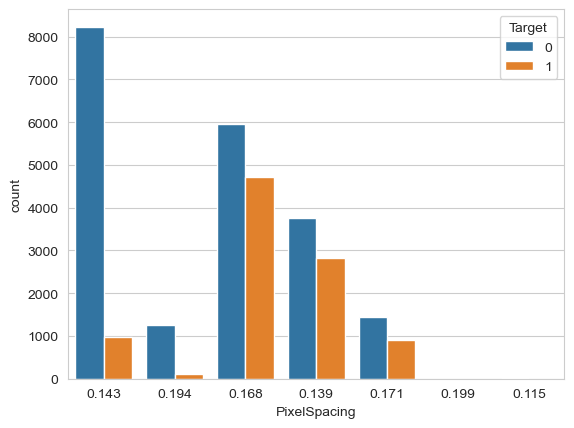

In [98]:
sns.countplot(x='PixelSpacing',hue='Target',data=traindf)

**0.115 Pixel spacing for age between 2-11 years. and 0.199 is from 20-35 age group. we have very less data points for this.**

In [99]:
traindf[traindf['PixelSpacing']=='0.199']

patientId      x      y  width  height  \
673    09714ab6-5dce-4ded-94cc-f79a47b4b171    NaN    NaN    NaN     NaN   
16521  9fae656b-cf66-4c4b-a5ed-1962ebcafb7d  651.0  346.0  275.0   210.0   
16522  9fae656b-cf66-4c4b-a5ed-1962ebcafb7d  262.0  354.0  240.0   156.0   
20838  bda68f49-6eb2-4afa-86bf-89a3d4378100  634.0  436.0  217.0   167.0   
20839  bda68f49-6eb2-4afa-86bf-89a3d4378100  389.0  395.0  142.0   181.0   

       Target                         class Modality PatientAge PatientSex  \
673         0  No Lung Opacity / Not Normal       CR         25          M   
16521       1                  Lung Opacity       CR         38          M   
16522       1                  Lung Opacity       CR         38          M   
20838       1                  Lung Opacity       CR         23          F   
20839       1                  Lung Opacity       CR         23          F   

      BodyPartExamined  ViewPosition ConversionType  Rows Columns PixelSpacing  
673              CHEST             0            WSD  1024    1024        0.199  
16521            CHEST             0            WSD  1024    1024        0.199  
16522            CHEST             0            WSD  1024    1024        0.199  
20838            CHEST             0            WSD  1024    1024        0.199  
20839            CHEST             0            WSD  1024    1024        0.199

In [100]:
traindf[traindf['PixelSpacing']=='0.115']

patientId      x      y  width  height  \
9834   6a8a2a9b-b22e-471a-8b90-3c5f6496cee6    NaN    NaN    NaN     NaN   
15480  9746c15f-94d1-4528-aff0-8ef02ccccef0    NaN    NaN    NaN     NaN   
17741  a8f16478-b36a-4bc9-ac8a-75477d8ea168    NaN    NaN    NaN     NaN   
21089  bf494059-4fe2-4f8f-a503-c340105e56ce    NaN    NaN    NaN     NaN   
22215  c908770d-5bb8-479e-9112-ff9c47d07277    NaN    NaN    NaN     NaN   
24190  d9728525-2c4b-4526-bbf7-873831872a20  227.0  474.0  250.0   200.0   
26339  eb2225b3-b09e-408c-8c48-27b1bad103a9  265.0  643.0  125.0   102.0   
28660  fd6f8775-392d-4f85-bc25-398c02a30678    NaN    NaN    NaN     NaN   

       Target                         class Modality PatientAge PatientSex  \
9834        0                        Normal       CR          6          M   
15480       0  No Lung Opacity / Not Normal       CR          2          F   
17741       0  No Lung Opacity / Not Normal       CR          5          F   
21089       0                        Normal       CR          4          M   
22215       0  No Lung Opacity / Not Normal       CR         11          F   
24190       1                  Lung Opacity       CR          7          F   
26339       1                  Lung Opacity       CR          4          M   
28660       0                        Normal       CR          7          M   

      BodyPartExamined  ViewPosition ConversionType  Rows Columns PixelSpacing  
9834             CHEST             1            WSD  1024    1024        0.115  
15480            CHEST             0            WSD  1024    1024        0.115  
17741            CHEST             1            WSD  1024    1024        0.115  
21089            CHEST             1            WSD  1024    1024        0.115  
22215            CHEST             0            WSD  1024    1024        0.115  
24190            CHEST             0            WSD  1024    1024        0.115  
26339            CHEST             0            WSD  1024    1024        0.115  
28660            CHEST             0            WSD  1024    1024        0.115

In [101]:
traindf=traindf.drop(['Modality','ConversionType','BodyPartExamined','Rows','Columns'],1);

In [102]:
testdf=testdf.drop(['Modality','ConversionType','BodyPartExamined','Rows','Columns'],1);

In [103]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   patientId     30227 non-null  object 
 1   x             9555 non-null   float64
 2   y             9555 non-null   float64
 3   width         9555 non-null   float64
 4   height        9555 non-null   float64
 5   Target        30227 non-null  int64  
 6   class         30227 non-null  object 
 7   PatientAge    30227 non-null  object 
 8   PatientSex    30227 non-null  object 
 9   ViewPosition  30227 non-null  int32  
 10  PixelSpacing  30227 non-null  object 
dtypes: float64(4), int32(1), int64(1), object(5)
memory usage: 2.7+ MB


In [104]:
traindf[traindf['PatientAge'].isna()]

Empty DataFrame
Columns: [patientId, x, y, width, height, Target, class, PatientAge, PatientSex, ViewPosition, PixelSpacing]
Index: []

In [105]:
traindf.corr()

x         y     width    height    Target  ViewPosition
x             1.000000  0.007604 -0.058665  0.008256       NaN     -0.022248
y             0.007604  1.000000 -0.299897 -0.645369       NaN      0.124721
width        -0.058665 -0.299897  1.000000  0.597461       NaN     -0.087427
height        0.008256 -0.645369  0.597461  1.000000       NaN     -0.275490
Target             NaN       NaN       NaN       NaN  1.000000     -0.420189
ViewPosition -0.022248  0.124721 -0.087427 -0.275490 -0.420189      1.000000

# **‣ Step 6: Design, train and test basic CNN models for classification.**

In [106]:
classInfo = pd.read_csv(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_detailed_class_info.csv')
trainlabels = pd.read_csv(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv')
trainImagesPath = Path(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_images')

In [107]:
#let's see how many image we have in trainImagesPath
num_dicom = os.listdir(trainImagesPath)
print(len(num_dicom))

26684


In [108]:
print(classInfo.shape, trainlabels.shape)

(30227, 2) (30227, 6)


In [109]:
classInfo.head()

patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity

In [110]:
trainlabels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [111]:
pneumonia = pd.merge(classInfo, trainlabels, on='patientId', how='inner')

In [112]:
print(pneumonia.shape)

(37629, 7)


In [113]:
pneumonia.head()

patientId                         class      x  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal    NaN   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal    NaN   
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal    NaN   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal    NaN   
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity  264.0   

       y  width  height  Target  
0    NaN    NaN     NaN       0  
1    NaN    NaN     NaN       0  
2    NaN    NaN     NaN       0  
3    NaN    NaN     NaN       0  
4  152.0  213.0   379.0       1

In [114]:
len(pneumonia['patientId'])

37629

In [115]:
37629-30227

7402

**Because the patientId column is duplicated after merging detail_class and bbox_info, we must drop paitientId from detail_class.**

In [116]:
pneumonia = pd.concat([classInfo.drop(columns = 'patientId'), trainlabels], axis = 1)

In [117]:
#Here we go
pneumonia.shape

(30227, 7)

In [118]:
pneumonia['patientId'].nunique()

26684

In [119]:
# Add all Bound In Box parameters in 'bbox'
pneumonia['bbox'] = pneumonia[['x', 'y', 'height', 'width']].apply(lambda x: '-'.join(str(i) for i in x), axis=1)

In [120]:
pneumonia = pneumonia.drop(columns = ['x', 'y', 'height', 'width'])

In [121]:
pneumonia.head()

class                             patientId  Target  \
0  No Lung Opacity / Not Normal  0004cfab-14fd-4e49-80ba-63a80b6bddd6       0   
1  No Lung Opacity / Not Normal  00313ee0-9eaa-42f4-b0ab-c148ed3241cd       0   
2  No Lung Opacity / Not Normal  00322d4d-1c29-4943-afc9-b6754be640eb       0   
3                        Normal  003d8fa0-6bf1-40ed-b54c-ac657f8495c5       0   
4                  Lung Opacity  00436515-870c-4b36-a041-de91049b9ab4       1   

                      bbox  
0          nan-nan-nan-nan  
1          nan-nan-nan-nan  
2          nan-nan-nan-nan  
3          nan-nan-nan-nan  
4  264.0-152.0-379.0-213.0

In [122]:
path = r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_images/*.dcm'

images = os.listdir(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_images')

pneumonia['image_path'] = ''

for i in range(len(pneumonia)):
    patient_id = pneumonia['patientId'][i]
    image_path = os.path.join(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_images', patient_id + '.dcm')
    pneumonia['image_path'][i] = image_path

C:\Users\manve\AppData\Local\Temp\ipykernel_3252\158172902.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pneumonia['image_path'][i] = image_path


In [123]:
#look at the meta data of random image from train set
random_patient_id = pneumonia['patientId'].sample().values[0]
dicom_data = pydicom.read_file(image_path)


print(dicom_data)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.9955.1517874345.895762
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.9955.1517874345.895762
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [124]:
def read_and_resize_images(pneumonia):
    resized_images = []
    boxes = []
    for i in range(len(pneumonia)):
        patient_id = pneumonia['patientId'][i]
        image_path = pneumonia['image_path'][i]
        target = pneumonia['Target'][i]
        dicom_data = pydicom.read_file(image_path)
        img = dicom_data.pixel_array

        #Resize image to 224x224
        img = cv2.resize(img, (224, 224))
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        resized_images.append(img)
        boxes.append(np.array(target, dtype=np.float32))
    return np.array(resized_images), np.array(boxes)

# **Split the data to Train and Test**

In [125]:
X, y = read_and_resize_images(pneumonia[:1000])

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [127]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(800, 224, 224, 3) (800,)
(200, 224, 224, 3) (200,)


In [128]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [131]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom as dcm
from pathlib import Path
import os
from tqdm.notebook import tqdm
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Layer, Convolution2D, Dense, RandomRotation, RandomFlip, Resizing, Rescaling
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Input, ReLU, AveragePooling2D, Activation, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses, optimizers
from keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [132]:
classInfo = pd.read_csv(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_detailed_class_info.csv')
trainlabels = pd.read_csv(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_labels.csv')
trainImagesPath = Path(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_images')
testImagesPath = Path(r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_test_images')

train_meta = pd.concat([trainlabels, classInfo.drop(columns=['patientId'])], axis=1)

In [133]:
def save_img_from_dcm(dcm_dir, img_dir, patient_id):
    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    if os.path.exists(img_fp):
        return
    dcm_fp = os.path.join(dcm_dir, "{}.dcm".format(patient_id))
    img_1ch = pydicom.read_file(dcm_fp).pixel_array
    img_3ch = np.stack([img_1ch]*3, -1)

    img_fp = os.path.join(img_dir, "{}.jpg".format(patient_id))
    cv2.imwrite(img_fp, img_3ch)

In [134]:
def get_image(dcm_file):
    ADJUSTED_IMAGE_SIZE = 128
    dcm_data = dcm.read_file(dcm_file)
    img = dcm_data.pixel_array
    img = np.stack((img,) * 3, -1)

    img = np.array(img).astype(np.uint8)
    res = cv2.resize(img,(ADJUSTED_IMAGE_SIZE,ADJUSTED_IMAGE_SIZE), interpolation = cv2.INTER_LINEAR)
    return res

In [135]:
def read_train(rowData):
    imageList = []
    for index, row in tqdm(rowData.iterrows()):
        patientId = row.patientId
        dcm_file = r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_train_images/'+'{}.dcm'.format(patientId)
        imageList.append(get_image(dcm_file))

    return np.array(imageList)

In [136]:
def read_test(path):
    imageList = []
    for file_name in tqdm(os.listdir(path)):
        dcm_file = dcm_file = os.sep.join([path, file_name])
        imageList.append(get_image(dcm_file))
    return np.array(imageList)

test_images_path = r'C:\Users\manve\Downloads\rsna-pneumonia-detection-challenge\stage_2_test_images'
test_images = read_test(test_images_path)

train_images = read_train(trainlabels)
print(train_images.shape)

  0%|          | 0/3000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

(30227, 128, 128, 3)


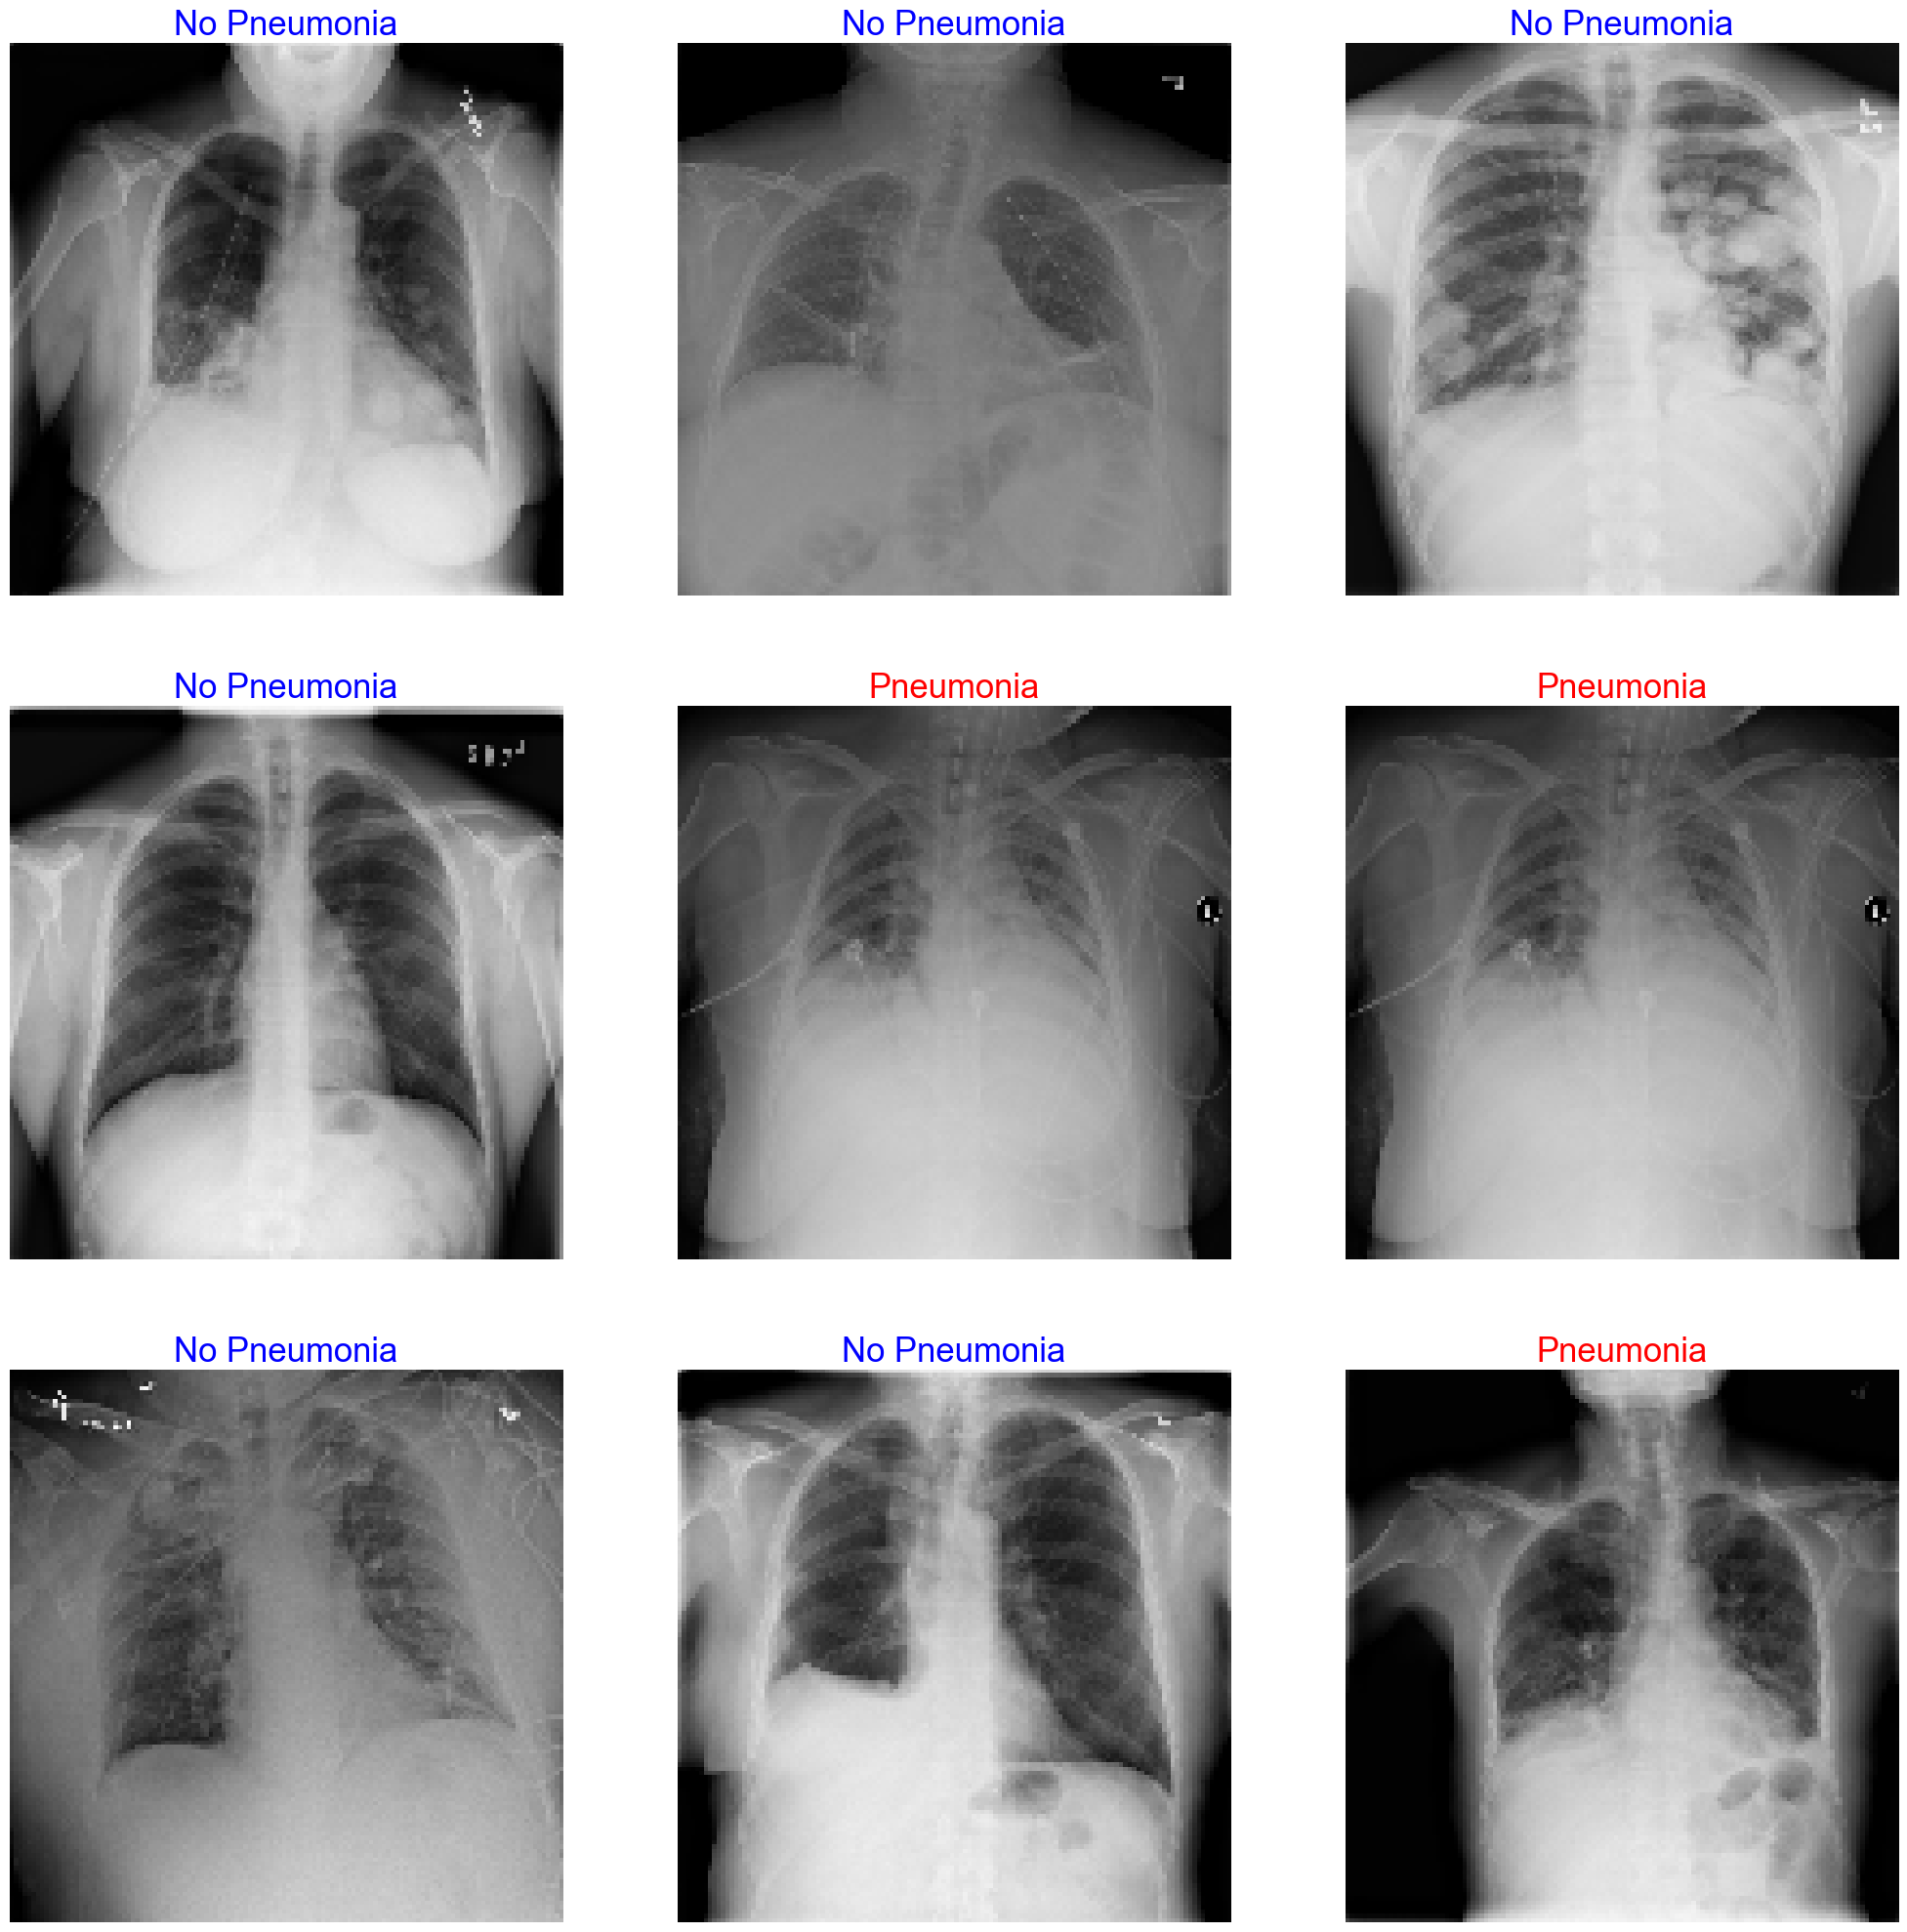

In [137]:
plt.figure(figsize=(25,25)) #
for i, image in enumerate(train_images[:9]):

    plt.subplot(3,3,i+1)
    plt.imshow(image)
    if trainlabels.loc[i]["Target"]:
        plt.title("Pneumonia", color="red", fontsize=25)
    else:
        plt.title("No Pneumonia", color="blue", fontsize=25)
    plt.axis('off')
plt.show()

In [138]:
y = pd.get_dummies(trainlabels["Target"]).values
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(train_images, y, test_size=0.2, random_state=random_state)

# **Building CNN Model**

In [139]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [153]:
ADJUSTED_IMAGE_SIZE = 128
input_shape = (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3)
num_classes = y_train.shape[1]

model = Sequential()
model.add(RandomRotation(factor=0.15))
model.add(Rescaling(1./255))
model.add(Conv2D(32, (3, 3), input_shape=input_shape)) # (3, 3) - conv kernel

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3)))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3)))

model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              metrics=['accuracy'] # ,f1_m
             )
# model.summary()

history = model.fit(X_train,
                  y_train,
                  epochs = 50,
                  validation_data = (X_test,y_test),
                  batch_size = 16,
                    callbacks=[
                        EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                    ]
                   )

fcl_loss, fcl_accuracy = model.evaluate(X_test, y_test, verbose=1) # , fcl_f1
print('Test loss:', fcl_loss)
print('Test accuracy:', fcl_accuracy)
# print('Test F1:', fcl_f1)

df = pd.DataFrame({"pred": np.argmax(model.predict(X_test), axis=1), "true": np.argmax(y_test, axis=1)})
print(classification_report(df["true"], df["pred"]))

Epoch 1/50
1512/1512 [==============================] - 155s 102ms/step - loss: 0.5459 - accuracy: 0.7181 - val_loss: 0.5144 - val_accuracy: 0.7585 - lr: 5.0000e-04
Epoch 2/50
1512/1512 [==============================] - 152s 101ms/step - loss: 0.5102 - accuracy: 0.7547 - val_loss: 0.4912 - val_accuracy: 0.7693 - lr: 5.0000e-04
Epoch 3/50
1512/1512 [==============================] - 161s 106ms/step - loss: 0.4946 - accuracy: 0.7675 - val_loss: 0.4911 - val_accuracy: 0.7663 - lr: 5.0000e-04
Epoch 4/50
1512/1512 [==============================] - 164s 108ms/step - loss: 0.4879 - accuracy: 0.7723 - val_loss: 0.4823 - val_accuracy: 0.7736 - lr: 5.0000e-04
Epoch 5/50
1512/1512 [==============================] - 157s 104ms/step - loss: 0.4839 - accuracy: 0.7766 - val_loss: 0.4860 - val_accuracy: 0.7670 - lr: 5.0000e-04
Epoch 6/50
1512/1512 [==============================] - 159s 105ms/step - loss: 0.4823 - accuracy: 0.7736 - val_loss: 0.4715 - val_accuracy: 0.7762 - lr: 5.0000e-04
Epoch 7/50

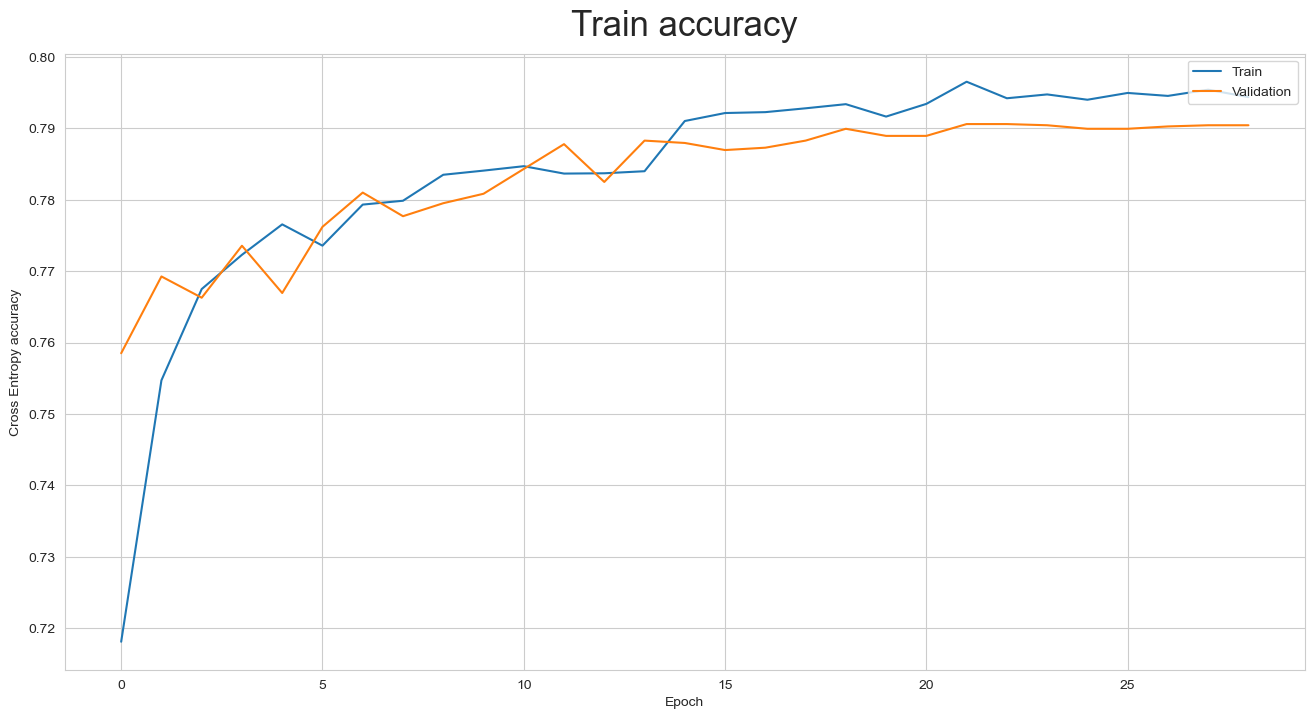

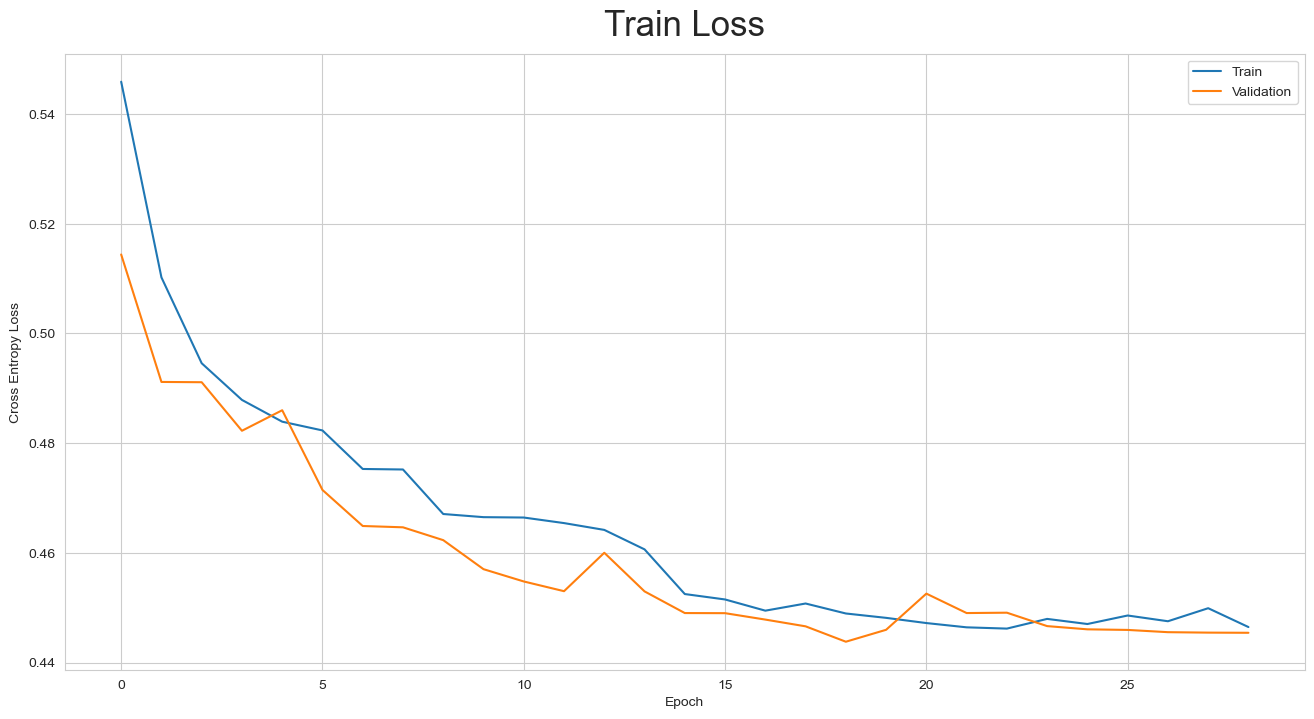

In [154]:
plt.figure(figsize=(16, 8))

plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.ylabel('Cross Entropy accuracy')
plt.xlabel('Epoch')
plt.title('Train accuracy', pad=13, fontsize=25)
plt.legend(loc='upper right')
plt.grid(000.1)

plt.show()


plt.figure(figsize=(16, 8))

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Epoch')
plt.title('Train Loss', pad=13, fontsize=25)
plt.legend(loc='upper right')
plt.grid(000.1)

plt.show()

**CNN model Accuracy is 79%.**